### Getting deeper with Keras

Tensorflow is a powerful and flexible tool, but coding large neural architectures with it is tedious. To speed things up, there's plenty of deep learning toolkits that work on top of it like Slim, TFLearn, Sonnet, Keras.

We'll be mostly focusing on Keras as it can be used both as auxiliary interface to TensorFlow and as standalone high-level library. We'll get you through on both of these in no time.

With acknowelagements to Alexandr Panin

In [1]:
import numpy as np
from mnist import load_dataset
import keras
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
y_train,y_val,y_test = map(keras.utils.np_utils.to_categorical,[y_train,y_val,y_test])

Using TensorFlow backend.


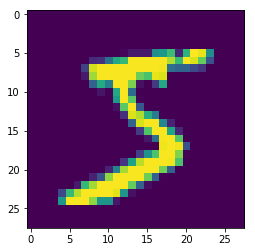

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0,0]);

## The pretty keras

The high-level Keras interface lets you define deep learning architectures from high-level building blocks like "Dense layer with nonlinearity", "dropout" or "batch normalization". Keras even takes the responsibility to handle dropouts correctly when evaluating.

This is convenient if you're building something commonplace like an image classifier. More delicate matters like sharing weight matrices or adversarial training (later) will get hacky.

In [3]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.1)
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [4]:
import keras
from keras.models import Sequential
import keras.layers as ll

model = Sequential(name="cnn")

model.add(ll.InputLayer([1,28,28]))

model.add(ll.Flatten())

#network body
model.add(ll.Dense(25))
model.add(ll.Activation('linear'))

model.add(ll.Dropout(0.9))

model.add(ll.Dense(25))
model.add(ll.Activation('linear'))

#output layer: 10 neurons for each class with softmax
model.add(ll.Dense(10,activation='softmax'))

model.compile("adam","categorical_crossentropy",metrics=["accuracy"])

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                19625     
_________________________________________________________________
activation_1 (Activation)    (None, 25)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
activation_2 (Activation)    (None, 25)                0         
__________

### Model interface

Keras models follow __Scikit-learn__'s interface of fit/predict with some notable extensions. Let's take a tour.

In [6]:
#fit(X,y) with a neat automatic logging. Highly customizable under the hood.
model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=5)

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 2s - loss: 1.6446 - acc: 0.3663 - val_loss: 0.7213 - val_acc: 0.8679
Epoch 2/5
50000/50000 [==============================] - 2s - loss: 1.4630 - acc: 0.4236 - val_loss: 0.6448 - val_acc: 0.8762
Epoch 3/5
50000/50000 [==============================] - 2s - loss: 1.4236 - acc: 0.4327 - val_loss: 0.6205 - val_acc: 0.8745
Epoch 4/5
50000/50000 [==============================] - 2s - loss: 1.4168 - acc: 0.4314 - val_loss: 0.5983 - val_acc: 0.8718
Epoch 5/5
50000/50000 [==============================] - 2s - loss: 1.4053 - acc: 0.4383 - val_loss: 0.5856 - val_acc: 0.8769


In [7]:
#estimate probabilities P(y|x)
model.predict_proba(X_val[:2])

2/2 [==============================] - 0s


array([[ 0.00432349,  0.08732168,  0.14439398,  0.56199145,  0.0021231 ,
         0.09007788,  0.00250137,  0.00134864,  0.10512118,  0.00079716],
       [ 0.00718338,  0.03731244,  0.03996421,  0.15714584,  0.0167062 ,
         0.24444814,  0.00697482,  0.00139083,  0.48427391,  0.00460027]], dtype=float32)

In [8]:
#Save trained weights
model.save("weights.h5")

In [9]:
print("\nLoss, Accuracy = ",model.evaluate(X_test,y_test))

 9056/10000 [==========================>...] - ETA: 0s
Loss, Accuracy =  [0.59707957315444948, 0.87109999999999999]


### Whoops!
So far our model is staggeringly inefficient. It didn't even beat the linear model (val_acc ~0.92). Guess, why?

There's an error that causes your model to underfit, and another error that prevents it from learning nonlinear dependencies. Try fixing both and play with the network architecture until you beat the thresholds below.

In [10]:
# Test score...
test_predictions = model.predict_proba(X_test).argmax(axis=-1)
test_answers = y_test.argmax(axis=-1)

test_accuracy = np.mean(test_predictions==test_answers)

print("\nTest accuracy: {} %".format(test_accuracy*100))

assert test_accuracy>=0.92,"Logistic regression can do better!"
assert test_accuracy>=0.975,"Your network can do better!"
print("Great job!")

 7488/10000 [=====================>........] - ETA: 0s
Test accuracy: 87.11 %


AssertionError: Logistic regression can do better!

## Keras + tensorboard

Remember the interactive graphs from Tensorboard one notebook ago? 

Thing is, Keras can use tensorboard to show you a lot of useful information about the learning progress. Just take a look!

In [ ]:
model = Sequential(name="cnn")

model.add(ll.InputLayer([1,28,28]))
model.add(ll.Flatten())

<Your architecture here>

#output layer: 10 neurons for each class with softmax
model.add(ll.Dense(10,activation='softmax'))

model.compile("adam","categorical_crossentropy",metrics=["accuracy"])


In [ ]:
from keras.callbacks import TensorBoard
model.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=10,
          callbacks=[TensorBoard("./logs")])

In [ ]:
import os
port = 6000 + os.getuid()
print("Port: %d" % port)
#!killall tensorboard
os.system("tensorboard --logdir=./logs --port=%d &" % port)

# Quest For A Better Network
Some tips on what you could do

 * __Network size__
   * More neurons, 
   * More layers, ([docs](https://keras.io/))
   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `keras.layers.Conv2D`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   * Plenty other layers and architectures
     * batch normalization, pooling, etc
     * Docs - https://keras.io/layers

 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
     

 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ FTW!
       * `keras.layers.normalization.BatchNormalization`


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - https://keras.io/regularizers/
   * Dropout - to prevent overfitting
     * `keras.layers.Dropout`   
     * Don't overdo it. Check if it actually makes your network better
   
   
 * __Data augmemntation__ - getting 5x as large dataset for free is a great deal
   * https://keras.io/preprocessing/image/
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
   
   
   
   
 
 
   
There is a template for your solution below that you can opt to use or throw away and write it your way